In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.modeling.models import Voigt1D
from astropy.modeling import fitting
import seaborn as sns
from lmfit import Model, Parameters
from scipy.ndimage import gaussian_filter
import math

In [2]:
def wavelength_edges(wavelength_data):
    diff = np.diff(wavelength_data)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) 
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) 
    w0 = wavelength_data - diff0/2.
    w1 = wavelength_data + diff1/2.

    return w0, w1

In [3]:
def smooth_data(wavelength_data, flux_data, error_data, sigma):
    # Smooth data
    smoothed_wavelength = gaussian_filter(wavelength_data, sigma)
    smoothed_flux = gaussian_filter(flux_data, sigma)
    smoothed_error = gaussian_filter(error_data, sigma)

    return smoothed_wavelength, smoothed_flux, smoothed_error

In [4]:
def grouping_emission_lines(min_wavelength, rest_lam_data):
    # Initialize variables
    tolerance = 10. # adjust me!
    ion_groups = {}
    close_group_found = False

    # Loop through emission lines
    for _, row in rest_lam_data.iterrows():
        # Extract ion name and wavelength
        ion = row["Ion"]
        wavelength = float(row["Wavelength"])

        if wavelength < min_wavelength: 
            continue

        # Check if ion already exists in the dictionary
        if ion not in ion_groups:
            ion_groups[ion] = [[wavelength]]
        else:
            # Reset
            close_group_found = False
            for group in ion_groups[ion]:
                # Check if the largest value in the group - wavelength is less than the tolerance
                if abs(max(group) - wavelength) <= tolerance:
                    group.append(wavelength)
                    close_group_found = True
                    break
            
            # If no close group was found
            if not close_group_found:
                ion_groups[ion].append([wavelength])

    return ion_groups

In [5]:
def split_create_trendline(wavelength_data, flux_data, peak_width_pixels):
    # Initialize variables
    length = len(wavelength_data) - 1
    flux_list_left = []
    flux_list_right = []
    
    # Make an array of all flux that aren't included in the peak
    for i in range(0, int(peak_width_pixels/2)):
        flux_list_left.append(flux_data[i])
        flux_list_right.append(flux_data[length-i])
        
    # Find the average flux for the left and right
    avg_flux_left = sum(flux_list_left)/len(flux_list_left)
    avg_flux_right = sum(flux_list_right)/len(flux_list_right)
    
    # Use the lesser of the two values as the average flux
    if avg_flux_left < avg_flux_right:
        avg_flux = avg_flux_left
    else:
        avg_flux = avg_flux_right
    
    continuum_array = [avg_flux for i in range(length + 1)]
    
    return continuum_array

In [6]:
def peak_width_finder(grating, wavelength_data):
    # Check grating
    if 'L' in grating:
        peak_width = 5.0
    else:
        peak_width = 0.5
        
    flux_range = 2*peak_width

    # Flux range in pixels calculation
    angstroms_to_pixels = wavelength_data[1] - wavelength_data[0] # NOTE! have to recalculate this number every time
    peak_width_pixels = math.floor(peak_width/angstroms_to_pixels)

    return peak_width, peak_width_pixels, flux_range

In [7]:
# Rest wavelengths
data = pd.read_csv("../DEM_goodlinelist .csv")
rest_df = pd.DataFrame(data)
rest_df.head(3)

,Ion,Wavelength,Likelihood to measure,Log Formation Temperature
0,S VI,933.397,Medium,5.3
1,N III,989.787,Medium,4.9
2,N III,991.495,Medium,4.9


In [8]:
# Group wavelengths
grouped_rest_data = grouping_emission_lines(1160, rest_df)

In [9]:
# HD 191939 data
data = fits.getdata('of0e53010_test_new_x1d.fits')
w, f , e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = (w > 1160) 
hd_wavelength_data, hd_flux_data, hd_error_data = w[mask], f[mask], e[mask]

# Print ecsv
hd191939_table = Table.read('hd-191939.ecsv', format='ascii.ecsv')
hd191939_df = hd191939_table.to_pandas()
hd191939_df.head(3)

,Ion,Rest Wavelength,Flux,Error,Blended Line
0,C III,1176.372,7.999070e-16,2.750151e-16,True
1,Si III,1206.499,-7.143874e-16,0.000000e+00,False
2,Si III,1303.323,-7.919437e-16,0.000000e+00,True


In [10]:
# Tau Ceti data
data = fits.getdata('hlsp_muscles_hst_stis_tau_ceti_e140m_v1_component-spec.fits')
w, f , e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = (w > 1160) # change if the spectra starts at a different wavelength
tc_wavelength_data, tc_flux_data, tc_error_data = w[mask], f[mask], e[mask]

# Print ecsv 
tc_table = Table.read('tau-ceti.ecsv', format='ascii.ecsv')
tc_df = tc_table.to_pandas()
tc_df.head(3)

,Ion,Rest Wavelength,Flux,Error,Blended Line
0,C III,1176.372,1.467025e-14,1.179191e-15,True
1,Si III,1206.499,3.085698e-14,8.772685e-16,False
2,Si III,1303.323,-1.681547e-15,0.000000e+00,True


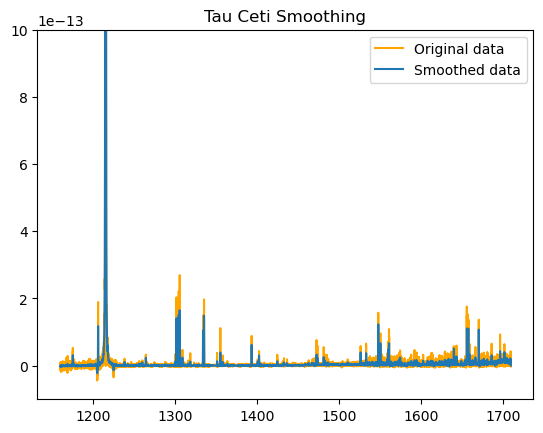

In [11]:
# Gaussian smoothing for tau ceti 
smoothtc_wavelength_data, smoothtc_flux_data, smoothtc_error_data = smooth_data(tc_wavelength_data, tc_flux_data, tc_error_data, 4)
plt.plot(tc_wavelength_data, tc_flux_data, label = 'Original data', color = 'orange')
plt.plot(smoothtc_wavelength_data, smoothtc_flux_data, label = 'Smoothed data')

plt.title("Tau Ceti Smoothing")
plt.ylim(-1e-13, 1e-12)
plt.legend()
plt.show()

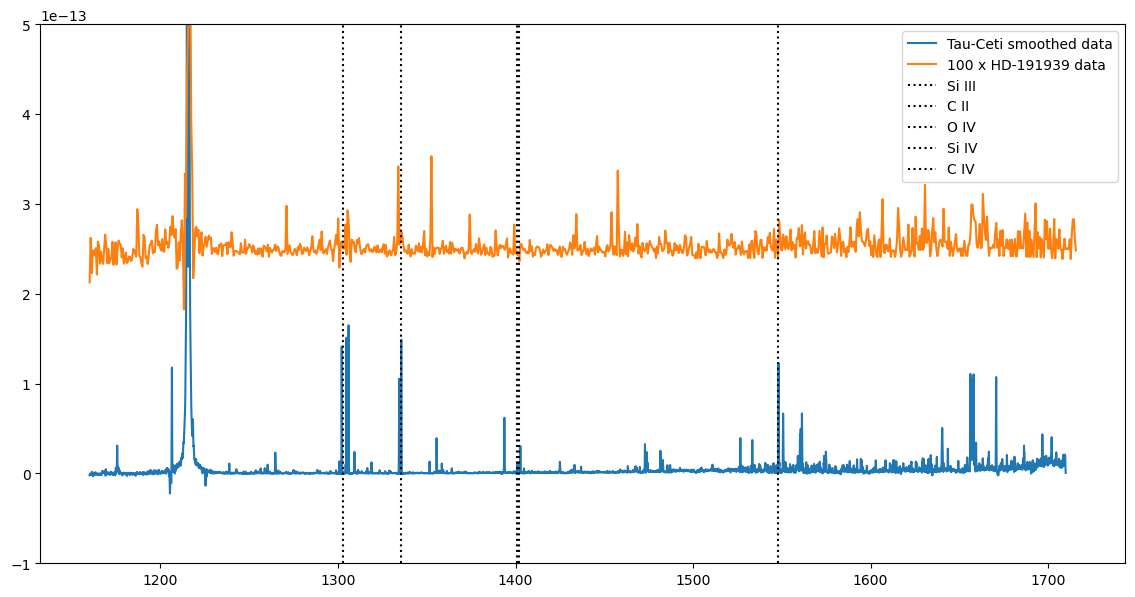

In [12]:
# Compare to HD-191939
plt.figure(figsize=(14,7))
plt.plot(smoothtc_wavelength_data, smoothtc_flux_data, label = 'Tau-Ceti smoothed data')
plt.plot(hd_wavelength_data, 2.5e-13 + 100*hd_flux_data, label = '100 x HD-191939 data')

# Plot line comparisons
plt.axvline(x = 1303, color = 'black', ls = 'dotted', label= 'Si III')
plt.axvline(x = 1335.709, color = 'black', ls = 'dotted', label= 'C II')
plt.axvline(x = 1401, color = 'black', ls = 'dotted', label= 'O IV')
plt.axvline(x = 1402, color = 'black', ls = 'dotted', label= 'Si IV')
plt.axvline(x = 1548, color = 'black', ls = 'dotted', label= 'C IV')

plt.ylim(-1e-13, 5e-13)
plt.legend()
plt.show()

#### HD-191939 data is scaled up 100 time!

### C II @ 1335.709

In [13]:
# Si II @ 1264 A
cII_lines = grouped_rest_data['C II'][1]
print(f'C II lines at {cII_lines}')

C II lines at [1334.524, 1335.709]


Flux at C II for Tau Ceti: 6.564371990657314e-14


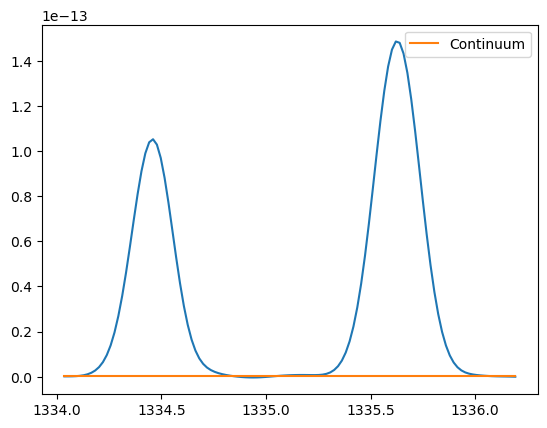

In [14]:
# Tau Ceti
tc_peak_width = 0.5
tc_cII_mask = (smoothtc_wavelength_data > cII_lines[0] - tc_peak_width) & (smoothtc_wavelength_data < cII_lines[1] + tc_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('E140M', smoothtc_wavelength_data[tc_cII_mask])
continuum = split_create_trendline(smoothtc_wavelength_data[tc_cII_mask], smoothtc_flux_data[tc_cII_mask], peak_width_pixels)

# Calculate the flux
w0,w1 = wavelength_edges(smoothtc_wavelength_data[tc_cII_mask])
total_sumflux = np.sum(smoothtc_flux_data[tc_cII_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
tc_cII_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at C II for Tau Ceti: {tc_cII_total_flux}')

plt.plot(smoothtc_wavelength_data[tc_cII_mask], smoothtc_flux_data[tc_cII_mask])
plt.plot(smoothtc_wavelength_data[tc_cII_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

Flux at C II for Tau Ceti: 9.859389895471236e-16


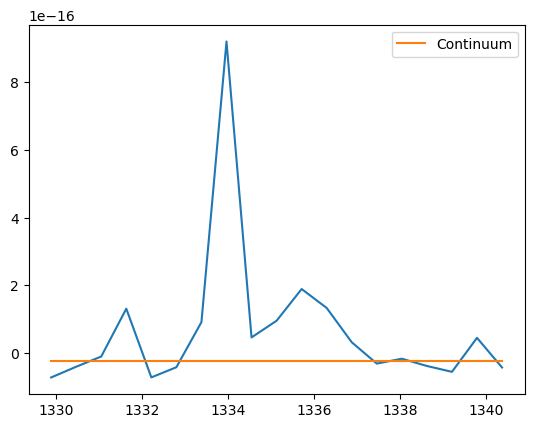

In [15]:
# HD-191939
hd_peak_width = 5.0
hd_cII_mask = (hd_wavelength_data > cII_lines[0] - hd_peak_width) & (hd_wavelength_data < cII_lines[1] + hd_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('L', hd_wavelength_data[hd_cII_mask])
continuum = split_create_trendline(hd_wavelength_data[hd_cII_mask], hd_flux_data[hd_cII_mask], peak_width_pixels)

# Calculate the flux
w0,w1 = wavelength_edges(hd_wavelength_data[hd_cII_mask])
total_sumflux = np.sum(hd_flux_data[hd_cII_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
hd_cII_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at C II for Tau Ceti: {hd_cII_total_flux}')

plt.plot(hd_wavelength_data[hd_cII_mask], hd_flux_data[hd_cII_mask])
plt.plot(hd_wavelength_data[hd_cII_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

In [16]:
# Ratio
cII_ratio = tc_cII_total_flux/hd_cII_total_flux
print(f'Flux ratio: {cII_ratio}')

Flux ratio: 66.57990058464532


### O IV @ 1401.171

In [17]:
# O IV @ 1401.171 A
oIV_lines = grouped_rest_data['O IV'][0]
print(f'O IV lines at {oIV_lines}')

O IV lines at [1399.779, 1401.171, 1407.383]


Flux at O IV for Tau Ceti: 1.6559411963980093e-14


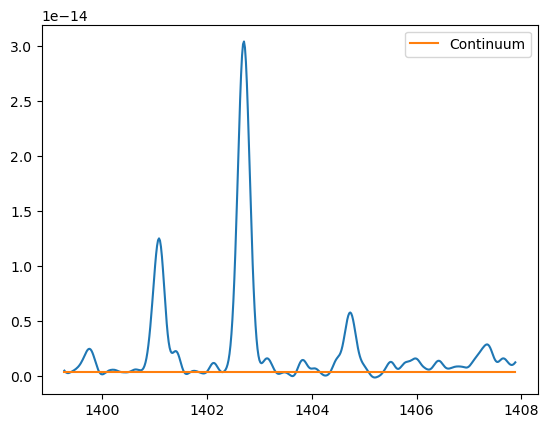

In [18]:
# Tau Ceti
tc_peak_width = 0.5
tc_oIV_mask = (smoothtc_wavelength_data > oIV_lines[0] - tc_peak_width) & (smoothtc_wavelength_data < oIV_lines[2] + tc_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('E140M', smoothtc_wavelength_data[tc_oIV_mask])
continuum = split_create_trendline(smoothtc_wavelength_data[tc_oIV_mask], smoothtc_flux_data[tc_oIV_mask], peak_width_pixels)

# Calculate the flux
w0,w1 = wavelength_edges(smoothtc_wavelength_data[tc_oIV_mask])
total_sumflux = np.sum(smoothtc_flux_data[tc_oIV_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
tc_oIV_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at O IV for Tau Ceti: {tc_oIV_total_flux}')

plt.plot(smoothtc_wavelength_data[tc_oIV_mask], smoothtc_flux_data[tc_oIV_mask])
plt.plot(smoothtc_wavelength_data[tc_oIV_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

Flux at O IV for Tau Ceti: 1.3865772232699894e-15


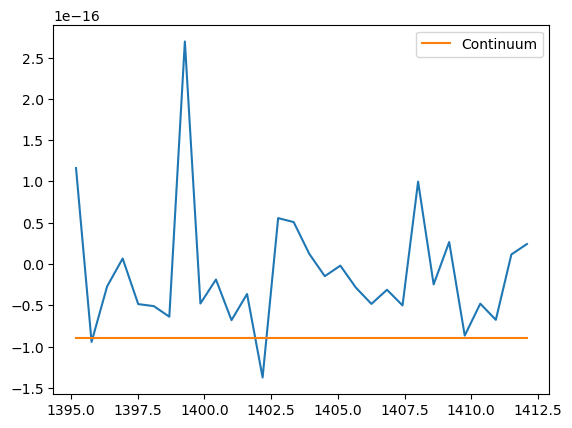

In [19]:
# HD-191939
hd_peak_width = 5.0
hd_oIV_mask = (hd_wavelength_data > oIV_lines[0] - hd_peak_width) & (hd_wavelength_data < oIV_lines[2] + hd_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('L', hd_wavelength_data[hd_oIV_mask])
continuum = [-0.9e-16 for _ in range(len(hd_wavelength_data[hd_oIV_mask]))]# hard coded

# Calculate the flux
w0,w1 = wavelength_edges(hd_wavelength_data[hd_oIV_mask])
total_sumflux = np.sum(hd_flux_data[hd_oIV_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
hd_oIV_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at O IV for Tau Ceti: {hd_oIV_total_flux}')

plt.plot(hd_wavelength_data[hd_oIV_mask], hd_flux_data[hd_oIV_mask])
plt.plot(hd_wavelength_data[hd_oIV_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

In [20]:
# Ratio
oIV_ratio = tc_oIV_total_flux/hd_oIV_total_flux
print(f'Flux ratio: {oIV_ratio}')

Flux ratio: 11.942653958304422


### Si III @ 1294.543

In [21]:
# S III @ 1294.543 A
siIII_lines = grouped_rest_data['Si III'][1]
print(f'Si III lines at {siIII_lines}')

Si III lines at [1294.543, 1296.726, 1298.892, 1298.944, 1301.147, 1303.323]


Flux at O IV for Tau Ceti: 4.266068654640219e-14


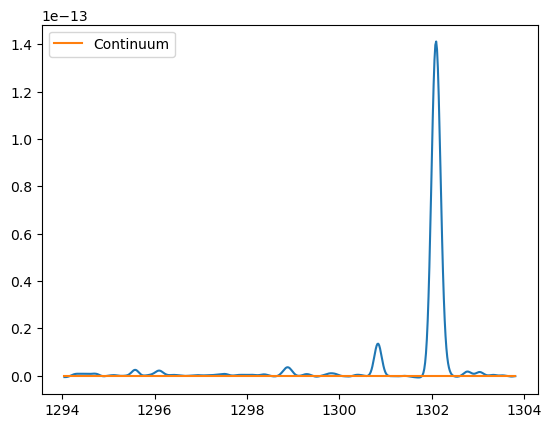

In [22]:
# Tau Ceti
tc_peak_width = 0.5
tc_siIII_mask = (smoothtc_wavelength_data > siIII_lines[0] - tc_peak_width) & (smoothtc_wavelength_data < siIII_lines[5] + tc_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('E140M', smoothtc_wavelength_data[tc_siIII_mask])
continuum = split_create_trendline(smoothtc_wavelength_data[tc_siIII_mask], smoothtc_flux_data[tc_siIII_mask], peak_width_pixels)

# Calculate the flux
w0,w1 = wavelength_edges(smoothtc_wavelength_data[tc_siIII_mask])
total_sumflux = np.sum(smoothtc_flux_data[tc_siIII_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
tc_siIII_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at O IV for Tau Ceti: {tc_siIII_total_flux}')

plt.plot(smoothtc_wavelength_data[tc_siIII_mask], smoothtc_flux_data[tc_siIII_mask])
plt.plot(smoothtc_wavelength_data[tc_siIII_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

Flux at O IV for Tau Ceti: 1.6905696961107819e-15


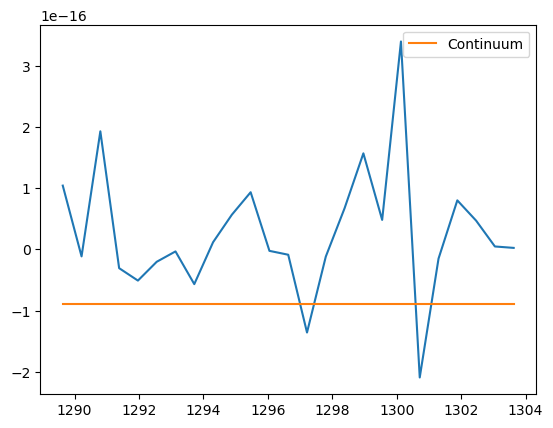

In [23]:
# HD-191939
hd_peak_width = 5.0
hd_siIII_mask = (hd_wavelength_data > siIII_lines[0] - hd_peak_width) & (hd_wavelength_data < siIII_lines[2] + hd_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('L', hd_wavelength_data[hd_siIII_mask])
continuum = [-0.9e-16 for _ in range(len(hd_wavelength_data[hd_siIII_mask]))]# hard coded

# Calculate the flux
w0,w1 = wavelength_edges(hd_wavelength_data[hd_siIII_mask])
total_sumflux = np.sum(hd_flux_data[hd_siIII_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
hd_siIII_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at O IV for Tau Ceti: {hd_siIII_total_flux}')

plt.plot(hd_wavelength_data[hd_siIII_mask], hd_flux_data[hd_siIII_mask])
plt.plot(hd_wavelength_data[hd_siIII_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

In [24]:
# Ratio
siIII_ratio = tc_siIII_total_flux/hd_siIII_total_flux
print(f'Flux ratio: {siIII_ratio}')

Flux ratio: 25.234503282854696


### Si IV @ 1402.77

In [25]:
# Si IV @ 1402.77 A
siIV_lines = grouped_rest_data['Si IV'][0]
print(f'Si IV lines at {siIV_lines}')

Si IV lines at [1393.755, 1402.77]


Flux at O IV for Tau Ceti: 2.4119980895185565e-14


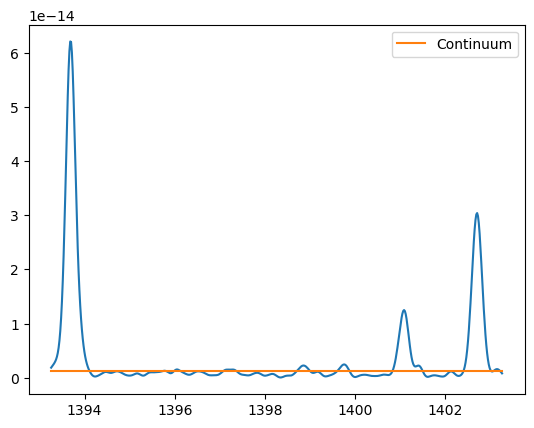

In [26]:
# Tau Ceti
tc_peak_width = 0.5
tc_siIV_mask = (smoothtc_wavelength_data > siIV_lines[0] - tc_peak_width) & (smoothtc_wavelength_data < siIV_lines[1] + tc_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('E140M', smoothtc_wavelength_data[tc_siIV_mask])
continuum = split_create_trendline(smoothtc_wavelength_data[tc_siIV_mask], smoothtc_flux_data[tc_siIV_mask], peak_width_pixels)

# Calculate the flux
w0,w1 = wavelength_edges(smoothtc_wavelength_data[tc_siIV_mask])
total_sumflux = np.sum(smoothtc_flux_data[tc_siIV_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
tc_siIV_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at O IV for Tau Ceti: {tc_siIV_total_flux}')

plt.plot(smoothtc_wavelength_data[tc_siIV_mask], smoothtc_flux_data[tc_siIV_mask])
plt.plot(smoothtc_wavelength_data[tc_siIV_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

Flux at O IV for Tau Ceti: 1.7670621470516858e-15


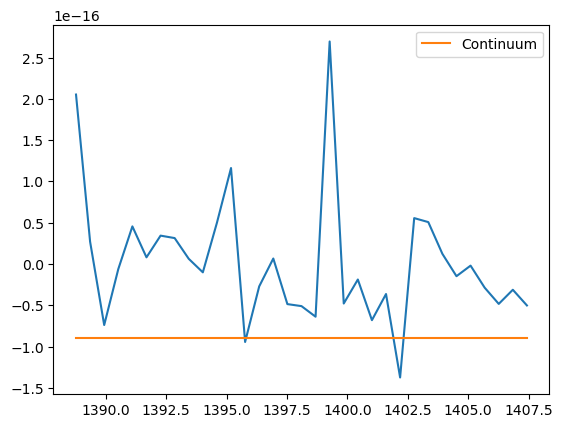

In [27]:
# HD-191939
hd_peak_width = 5.0
hd_siIV_mask = (hd_wavelength_data > siIV_lines[0] - hd_peak_width) & (hd_wavelength_data < siIV_lines[1] + hd_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('L', hd_wavelength_data[hd_siIV_mask])
continuum = [-0.9e-16 for _ in range(len(hd_wavelength_data[hd_siIV_mask]))]# hard coded

# Calculate the flux
w0,w1 = wavelength_edges(hd_wavelength_data[hd_siIV_mask])
total_sumflux = np.sum(hd_flux_data[hd_siIV_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
hd_siIV_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at O IV for Tau Ceti: {hd_siIV_total_flux}')

plt.plot(hd_wavelength_data[hd_siIV_mask], hd_flux_data[hd_siIV_mask])
plt.plot(hd_wavelength_data[hd_siIV_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

In [28]:
# Ratio
siIV_ratio = tc_siIV_total_flux/hd_siIV_total_flux
print(f'Flux ratio: {siIV_ratio}')

Flux ratio: 13.649763781896047


### C IV @ 1548.201

In [29]:
# C IV @ 1548.201 A
cIV_lines = grouped_rest_data['C IV'][0]
print(f'C IV lines at {cIV_lines}')

C IV lines at [1548.201, 1550.772]


Flux at O IV for Tau Ceti: 5.42708971305996e-14


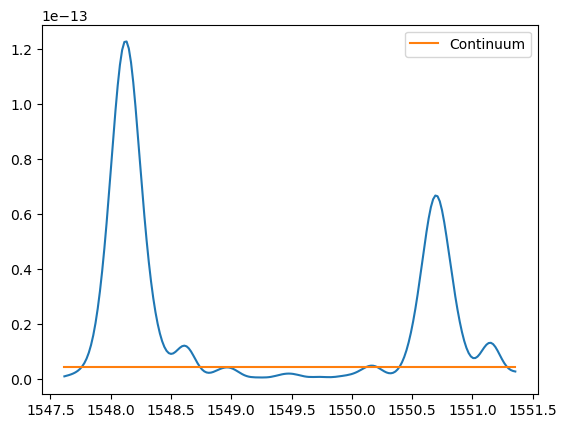

In [30]:
# Tau Ceti
tc_peak_width = 0.6
tc_cIV_mask = (smoothtc_wavelength_data > cIV_lines[0] - tc_peak_width) & (smoothtc_wavelength_data < cIV_lines[1] + tc_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('E140M', smoothtc_wavelength_data[tc_cIV_mask])
continuum = split_create_trendline(smoothtc_wavelength_data[tc_cIV_mask], smoothtc_flux_data[tc_cIV_mask], peak_width_pixels)

# Calculate the flux
w0,w1 = wavelength_edges(smoothtc_wavelength_data[tc_cIV_mask])
total_sumflux = np.sum(smoothtc_flux_data[tc_cIV_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
tc_cIV_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at O IV for Tau Ceti: {tc_cIV_total_flux}')

plt.plot(smoothtc_wavelength_data[tc_cIV_mask], smoothtc_flux_data[tc_cIV_mask])
plt.plot(smoothtc_wavelength_data[tc_cIV_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

Flux at O IV for Tau Ceti: 2.2383352018210776e-15


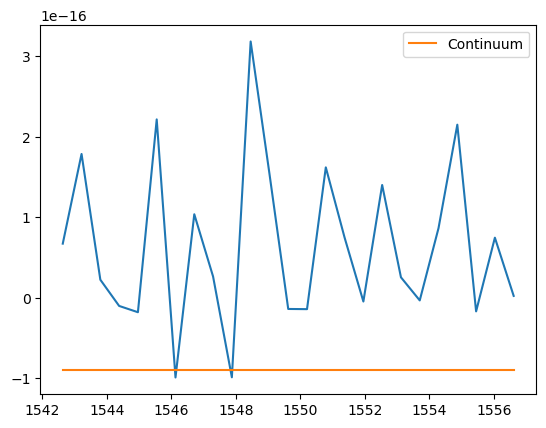

In [31]:
# HD-191939
hd_peak_width = 6.0
hd_cIV_mask = (hd_wavelength_data > cIV_lines[0] - hd_peak_width) & (hd_wavelength_data < cIV_lines[1] + hd_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('L', hd_wavelength_data[hd_cIV_mask])
continuum = [-0.9e-16 for _ in range(len(hd_wavelength_data[hd_cIV_mask]))]# hard coded

# Calculate the flux
w0,w1 = wavelength_edges(hd_wavelength_data[hd_cIV_mask])
total_sumflux = np.sum(hd_flux_data[hd_cIV_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
hd_cIV_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at O IV for Tau Ceti: {hd_cIV_total_flux}')

plt.plot(hd_wavelength_data[hd_cIV_mask], hd_flux_data[hd_cIV_mask])
plt.plot(hd_wavelength_data[hd_cIV_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

In [32]:
# Ratio
cIV_ratio = tc_cIV_total_flux/hd_cIV_total_flux
print(f'Flux ratio: {cIV_ratio}')

Flux ratio: 24.24609910367561


### He II @ 1640.42

In [33]:
# He II @ 1640.42 A
heII_lines = grouped_rest_data['He II'][0]
print(f'Si IV lines at {heII_lines}')

Si IV lines at [1640.42]


Flux at O IV for Tau Ceti: 2.20560861021447e-14


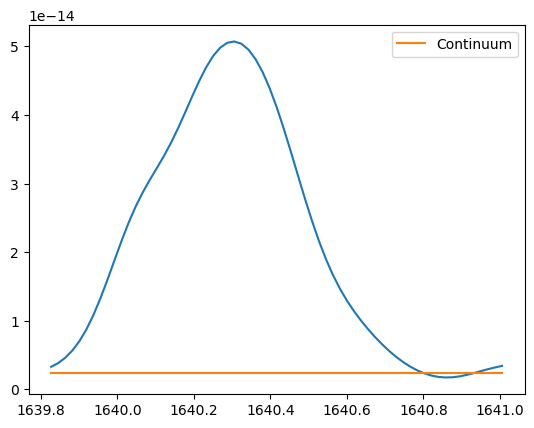

In [34]:
# Tau Ceti
tc_peak_width = 0.6
tc_heII_mask = (smoothtc_wavelength_data > heII_lines[0] - tc_peak_width) & (smoothtc_wavelength_data < heII_lines[0] + tc_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('E140M', smoothtc_wavelength_data[tc_heII_mask])
continuum = split_create_trendline(smoothtc_wavelength_data[tc_heII_mask], smoothtc_flux_data[tc_heII_mask], peak_width_pixels)

# Calculate the flux
w0,w1 = wavelength_edges(smoothtc_wavelength_data[tc_heII_mask])
total_sumflux = np.sum(smoothtc_flux_data[tc_heII_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
tc_heII_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at O IV for Tau Ceti: {tc_heII_total_flux}')

plt.plot(smoothtc_wavelength_data[tc_heII_mask], smoothtc_flux_data[tc_heII_mask])
plt.plot(smoothtc_wavelength_data[tc_heII_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

Flux at O IV for Tau Ceti: 1.3964521505993655e-15


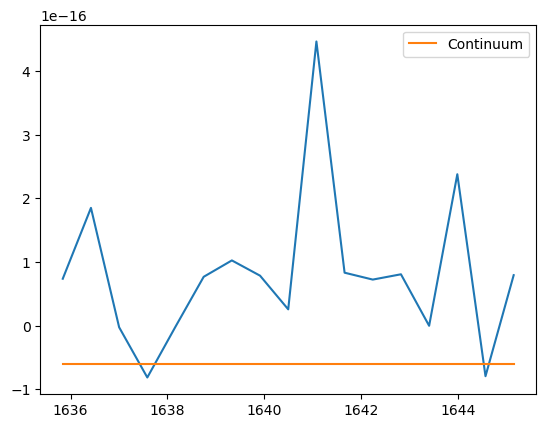

In [35]:
# HD-191939
hd_peak_width = 5.0
hd_heII_mask = (hd_wavelength_data > heII_lines[0] - hd_peak_width) & (hd_wavelength_data < heII_lines[0] + hd_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('L', hd_wavelength_data[hd_heII_mask])
continuum = [-0.6e-16 for _ in range(len(hd_wavelength_data[hd_heII_mask]))]# hard coded

# Calculate the flux
w0,w1 = wavelength_edges(hd_wavelength_data[hd_heII_mask])
total_sumflux = np.sum(hd_flux_data[hd_heII_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
hd_heII_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at O IV for Tau Ceti: {hd_heII_total_flux}')

plt.plot(hd_wavelength_data[hd_heII_mask], hd_flux_data[hd_heII_mask])
plt.plot(hd_wavelength_data[hd_heII_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

In [36]:
# Ratio
heII_ratio = tc_heII_total_flux/hd_heII_total_flux
print(f'Flux ratio: {heII_ratio}')

Flux ratio: 15.794372970586995


### O III @ 1666.142

In [37]:
# O III @ 1666.142 A
oIII_lines = grouped_rest_data['O III'][0]
print(f'Si IV lines at {oIII_lines}')

Si IV lines at [1666.142]


Flux at O IV for Tau Ceti: 6.802266603015589e-15


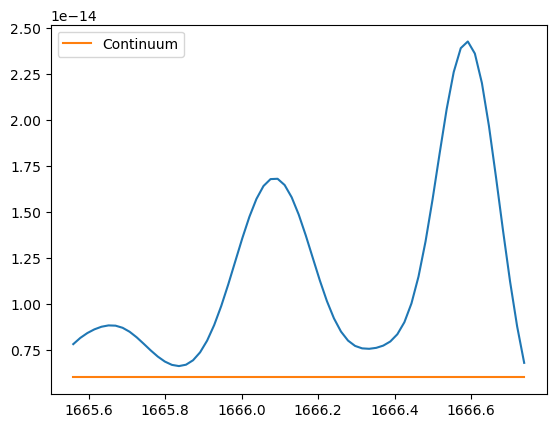

In [38]:
# Tau Ceti
tc_peak_width = 0.6
tc_oIII_mask = (smoothtc_wavelength_data > oIII_lines[0] - tc_peak_width) & (smoothtc_wavelength_data < oIII_lines[0] + tc_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('E140M', smoothtc_wavelength_data[tc_oIII_mask])
continuum = [0.6e-14 for _ in range(len(smoothtc_wavelength_data[tc_oIII_mask]))]# hard coded

# Calculate the flux
w0,w1 = wavelength_edges(smoothtc_wavelength_data[tc_oIII_mask])
total_sumflux = np.sum(smoothtc_flux_data[tc_oIII_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
tc_oIII_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at O IV for Tau Ceti: {tc_oIII_total_flux}')

plt.plot(smoothtc_wavelength_data[tc_oIII_mask], smoothtc_flux_data[tc_oIII_mask])
plt.plot(smoothtc_wavelength_data[tc_oIII_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

Flux at O IV for Tau Ceti: 1.5892675609211822e-15


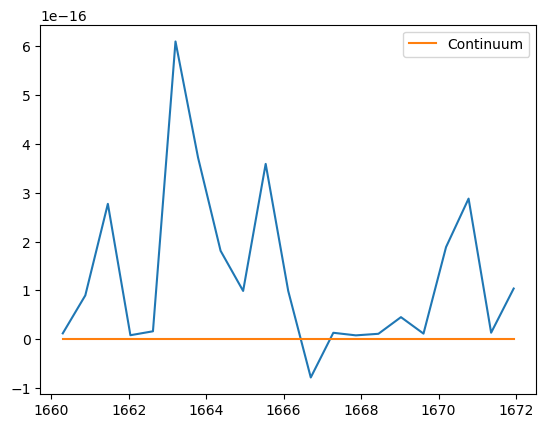

In [39]:
# HD-191939
hd_peak_width = 6.0
hd_oIII_mask = (hd_wavelength_data > oIII_lines[0] - hd_peak_width) & (hd_wavelength_data < oIII_lines[0] + hd_peak_width)

# Calculate the continuum 
peak_width, peak_width_pixels, flux_range = peak_width_finder('L', hd_wavelength_data[hd_oIII_mask])
continuum = [0e-16 for _ in range(len(hd_wavelength_data[hd_oIII_mask]))]# hard coded

# Calculate the flux
w0,w1 = wavelength_edges(hd_wavelength_data[hd_oIII_mask])
total_sumflux = np.sum(hd_flux_data[hd_oIII_mask]*(w1-w0))
continuum_sumflux = np.sum(continuum*(w1-w0))
hd_oIII_total_flux = total_sumflux - continuum_sumflux
print(f'Flux at O IV for Tau Ceti: {hd_oIII_total_flux}')

plt.plot(hd_wavelength_data[hd_oIII_mask], hd_flux_data[hd_oIII_mask])
plt.plot(hd_wavelength_data[hd_oIII_mask], continuum, label = 'Continuum')
plt.legend()
plt.show()

In [40]:
# Ratio
oIII_ratio = tc_oIII_total_flux/hd_oIII_total_flux
print(f'Flux ratio: {oIII_ratio}')

Flux ratio: 4.280126751642003


### Final comparisons

In [41]:
print(f'C II vs Si III: {cII_ratio/siIII_ratio} * 2 = {(cII_ratio/siIII_ratio)*2} \n')
print(f'C II vs O IV: {cII_ratio/oIV_ratio} / 2 = {(cII_ratio/oIV_ratio)/2} ')

C II vs Si III: 2.638447043650837 * 2 = 5.276894087301674 

C II vs O IV: 5.5749669057729365 / 2 = 2.7874834528864683 


In [42]:
# How to ge the ratios
print(f'CII ratio: {cII_ratio}\n')
print(f'Si III ratio: {siIII_ratio}')
print(f'C IV ratio: {cIV_ratio}\n')
print(f'O IV ratio: {oIV_ratio}')
print(f'Si IV ratio: {siIV_ratio}\n')

# Math 
print(f'Si III ratio = (2/5)x C II ratio -> {siIII_ratio * 2.5} ~ {cII_ratio}')
print(f'C IV ratio = (2/5)x C II ratio -> {cIV_ratio * 2.5} ~ {cII_ratio}\n')
print(f'O IV ratio = (1/5)x C II ratio -> {oIV_ratio * 5.0} ~ {cII_ratio}')
print(f'Si IV ratio = (1/5)x C II ratio -> {siIV_ratio * 5.0} ~ {cII_ratio}')

CII ratio: 66.57990058464532

Si III ratio: 25.234503282854696
C IV ratio: 24.24609910367561

O IV ratio: 11.942653958304422
Si IV ratio: 13.649763781896047

Si III ratio = (2/5)x C II ratio -> 63.08625820713674 ~ 66.57990058464532
C IV ratio = (2/5)x C II ratio -> 60.61524775918903 ~ 66.57990058464532

O IV ratio = (1/5)x C II ratio -> 59.71326979152211 ~ 66.57990058464532
Si IV ratio = (1/5)x C II ratio -> 68.24881890948024 ~ 66.57990058464532


In [43]:
# Calculate average ratio
avg_ratio = (cII_ratio + (siIII_ratio * 2.5) + (cIV_ratio * 2.5) + (oIV_ratio * 5.0) + (siIV_ratio * 5.0))/5
avg_ratio

63.64869905039468

In [44]:
# Tau Ceti vs HD-191939 comparison
print(f'Tau Ceti C II Flux = {tc_cII_total_flux}   ->    65 * (HD-191939 C II Flux) = {65 * hd_cII_total_flux}')
print(f'Therefore HD-191939 C II Flux =  (Tau Ceti C II Flux) / (65) = {tc_cII_total_flux/ 65}\n')

print(f'HD-191939 Si III Flux = {tc_siIII_total_flux}    ->    65 * (2/5) * (HD-191939 Si III Flux) = {65 * 2/5 * hd_siIII_total_flux}')
print(f'Therefore HD-191939 Si III Flux =  (Tau Ceti Si III Flux) / (65 * 2/5) = {tc_siIII_total_flux / (65 * (2/5))}\n')

print(f'Tau Ceti C IV Flux = {tc_cIV_total_flux}    ->    65 * (2/5) * (HD-191939 C IV Flux) = {65 * 2/5 * hd_cIV_total_flux}')
print(f'Therefore HD-191939 C IV Flux =  (Tau Ceti C IV Flux) / (65 * 2/5) = {tc_cIV_total_flux / (65 * (2/5))}\n')

print(f'Tau Ceti O IV Flux = {tc_oIV_total_flux}    ->    65 * (1/5) * (HD-191939 O IV Flux) = {65 * 1/5 * hd_oIV_total_flux}')
print(f'Therefore HD-191939 O IV Flux =  (Tau Ceti O IV Flux) / (65 * 1/5) = {tc_oIV_total_flux / (65 * (1/5))}\n')

print(f'Tau Ceti Si IV Flux = {tc_siIV_total_flux}    ->    65 * (1/5) * (HD-191939 Si IV Flux) = {65 * 1/5 * hd_siIV_total_flux}')
print(f'Therefore HD-191939 Si IV Flux =  (Tau Ceti Si IV Flux) / (65 * 1/5) = {tc_siIV_total_flux / (65 * (1/5))}\n')

Tau Ceti C II Flux = 6.564371990657314e-14   ->    65 * (HD-191939 C II Flux) = 6.408603432056303e-14
Therefore HD-191939 C II Flux =  (Tau Ceti C II Flux) / (65) = 1.0099033831780483e-15

HD-191939 Si III Flux = 4.266068654640219e-14    ->    65 * (2/5) * (HD-191939 Si III Flux) = 4.395481209888033e-14
Therefore HD-191939 Si III Flux =  (Tau Ceti Si III Flux) / (65 * 2/5) = 1.6407956364000843e-15

Tau Ceti C IV Flux = 5.42708971305996e-14    ->    65 * (2/5) * (HD-191939 C IV Flux) = 5.819671524734802e-14
Therefore HD-191939 C IV Flux =  (Tau Ceti C IV Flux) / (65 * 2/5) = 2.0873421973307536e-15

Tau Ceti O IV Flux = 1.6559411963980093e-14    ->    65 * (1/5) * (HD-191939 O IV Flux) = 1.8025503902509864e-14
Therefore HD-191939 O IV Flux =  (Tau Ceti O IV Flux) / (65 * 1/5) = 1.273800920306161e-15

Tau Ceti Si IV Flux = 2.4119980895185565e-14    ->    65 * (1/5) * (HD-191939 Si IV Flux) = 2.2971807911671915e-14
Therefore HD-191939 Si IV Flux =  (Tau Ceti Si IV Flux) / (65 * 1/5) = 1.85

### Plot of flux ratios + propogated uncertanities

In [45]:
"""
    Propagate uncertainties when taking a ratio of two arrays.

    Name:       prop_ratio_uncertainity()
    Parameters: 
                num: numerator array 
                denom: denominator array
                num_err: numerator error array
                denom_err: denominator error array
    Returns:
                ratio_uncertainty: uncertainity in ratio (num/denom)
"""
def prop_ratio_uncertainty(num, denom, num_err, denom_err):
    rel_num = num_err / num
    rel_denom = denom_err / denom
    ratio_uncertainty = np.sqrt(rel_num**2 + rel_denom**2) * np.abs(num / denom)
    return ratio_uncertainty

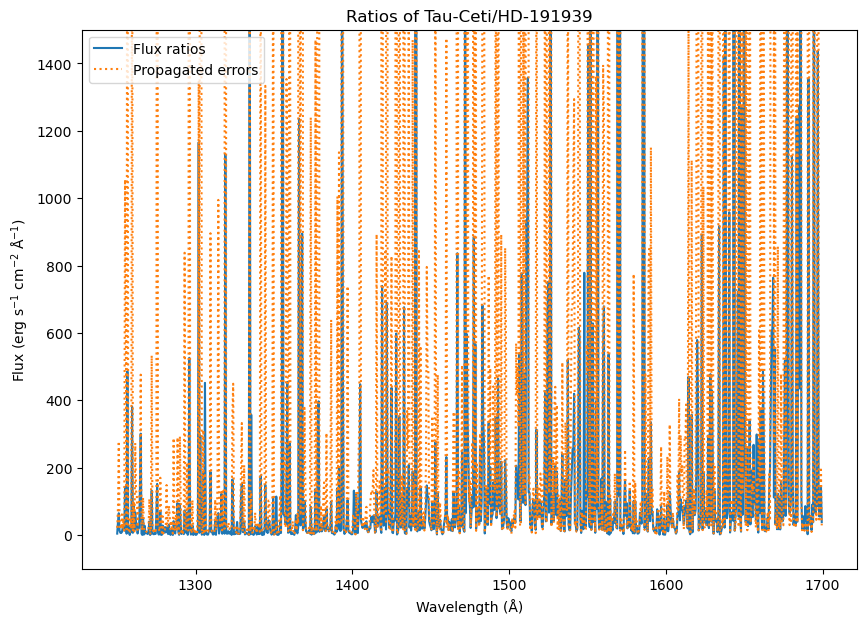

In [93]:
# Plot the fluxes of Tau-Ceti vs HD-191939 from 1160-1700
wavelength_values = [i/2 for i in range(2500, 3400)]
ratios = []
prop_errors = []

# Iterate through wavelengths
for wavelength in wavelength_values:
    # Get index of wavelength that is closest to wavelength values
    hd_closest_index = np.abs(hd_wavelength_data - wavelength).argmin()
    smoothtc_closest_index = np.abs(smoothtc_wavelength_data - wavelength).argmin()

    # Get the flux at those indicies
    hd_wavelength_flux, smoothtc_wavelength_flux = hd_flux_data[hd_closest_index], smoothtc_flux_data[smoothtc_closest_index]
    # Get the error at those indicies
    hd_wavelength_error, smoothtc_wavelength_error = hd_error_data[hd_closest_index], smoothtc_error_data[smoothtc_closest_index]
    
    # Calculate ratio and error
    ratio = np.abs(smoothtc_wavelength_flux/ hd_wavelength_flux)
    error = prop_ratio_uncertainty(smoothtc_wavelength_flux, hd_wavelength_flux, smoothtc_wavelength_error, hd_wavelength_error)
    ratios.append(ratio)
    prop_errors.append(error)

# Plot the uncertainity and the errors
plt.figure(figsize=(10,7))
plt.title('Ratios of Tau-Ceti/HD-191939')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
plt.ylim(-100, 1500)

plt.plot(wavelength_values, ratios, label = 'Flux ratios')
plt.plot(wavelength_values, prop_errors, label = 'Propagated errors', ls = 'dotted')
plt.legend()
plt.show()

In [106]:
sum(ratios)/ len(ratios)

673.4124522310593

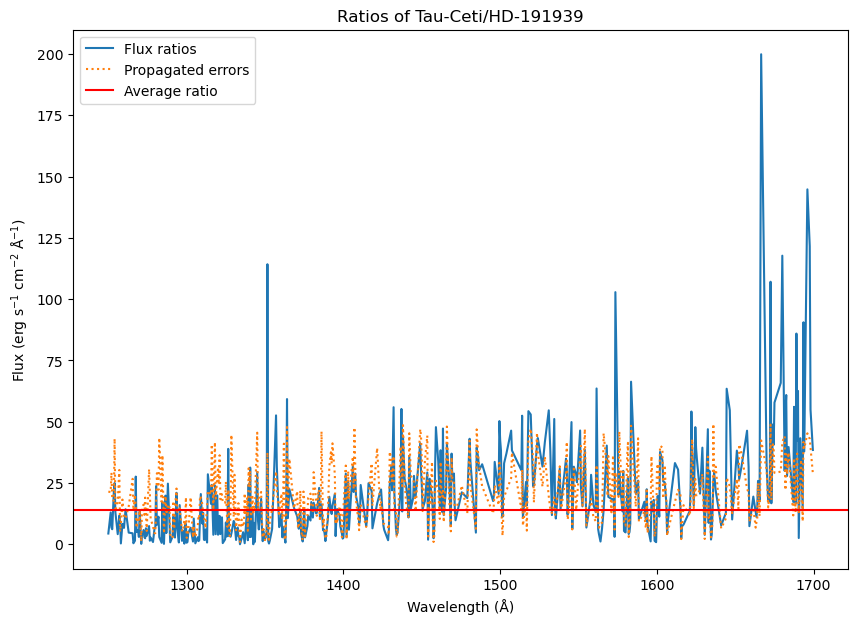

14.022247357031258

In [121]:
# Find best error 
cut_wavelengths, cut_ratios, cut_errors = [], [], []

for i in range(len(ratios)):
    if prop_errors[i] <= 50:
        cut_wavelengths.append(wavelength_values[i])
        cut_ratios.append(ratios[i])
        cut_errors.append(prop_errors[i])

plt.figure(figsize=(10,7))
plt.title('Ratios of Tau-Ceti/HD-191939')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')

plt.plot(cut_wavelengths, cut_ratios, label = 'Flux ratios')
plt.plot(cut_wavelengths, cut_errors, ls = 'dotted', label = 'Propagated errors')
plt.axhline(y=14, color = 'red', label = 'Average ratio')
plt.legend()
plt.show()

np.median(cut_ratios)

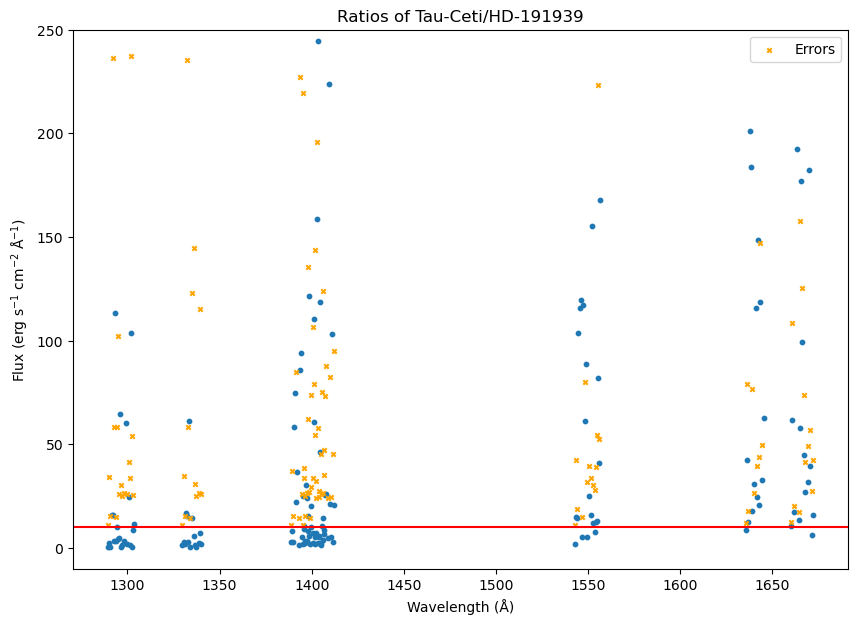

In [103]:
# Emission line only
emission_line_masks = [hd_cII_mask, hd_oIV_mask, hd_siIII_mask, hd_siIV_mask, hd_cIV_mask, hd_heII_mask, hd_oIII_mask]
emission_line_ratios = []
emission_line_errors = []
emission_line_wavelengths = []

for mask in emission_line_masks:
    for i, wavelength in enumerate(hd_wavelength_data[mask]):
        # Get the closest value to that wavelength in tau-ceti
        smoothtc_closest_index = np.abs(smoothtc_wavelength_data - wavelength).argmin()

        # Get the flux at those indicies
        smoothtc_emission_line_flux = smoothtc_flux_data[smoothtc_closest_index]
        # Get the error at those indicies
        smoothtc_emission_line_error = smoothtc_error_data[smoothtc_closest_index]

        # Calculate the ratio and error
        ratio = np.abs(smoothtc_emission_line_flux/ hd_flux_data[i])
        error = prop_ratio_uncertainty(smoothtc_emission_line_flux, hd_flux_data[i], smoothtc_wavelength_error, hd_wavelength_error)
        emission_line_ratios.append(ratio)
        emission_line_errors.append(error)
        emission_line_wavelengths.append(wavelength)
        

plt.figure(figsize=(10,7))
plt.title('Ratios of Tau-Ceti/HD-191939')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
plt.ylim(-10, 250)

plt.scatter(emission_line_wavelengths, emission_line_ratios, s = 10)
plt.scatter(emission_line_wavelengths, emission_line_errors, color = 'orange', marker = 'x', s = 10, label = 'Errors')
plt.axhline(y = 10, color = 'red')
plt.legend()
plt.show()

In [50]:
sum(emission_line_ratios) / len(emission_line_ratios)

1371.7917459411553